# Further ideas

#### This is not part of the official notebook!!! 

This was part of the old notebook, where LSTM and CNN models were trained on top of the word2vec-embeddings for text classification and can be used for further experiments/ideas. 

| Teammember |                    |
|------------|--------------------|
| 1.         | Nadine Weber    |
| 2.         | Patrick Singer      |
| 3.         | Milos Aleksic         |
---

## Tasks on Text Classification

In this section a CNN document classifier shall be defined, trained and evaluated with Keras. For this the basics of Keras, as described e.g. in this [Keras Tutorial](https://keras.io/about/), must be known. 

The classifier shall be able to distinguish RSS-feed news with technical content from general RSS-feed news. Training and evaluation data is available from the folder `./Data/GERMAN/`.  

In [1]:
# Import required libraries
import pandas as pd
import numpy as np 
import sklearn
import os
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Embedding
from tensorflow.keras.utils import to_categorical

print(f"Tensorflow version: {tf.__version__} | Keras version: {keras.__version__}")

2023-04-25 20:17:43.616326: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Tensorflow version: 2.4.1 | Keras version: 2.4.0


### Access locally stored RSS-feed news of both categories 
News crawled from RSS feeds of category `Tech` and `General` are stored in distinct directories. In the following code-cell the paths to both directories are configured. 

In [2]:
techpath="./Data/GERMAN/TECH/RSS/FeedText"
generalpath="./Data/GERMAN/GENERAL/RSS/FeedText"
catpaths=[techpath,generalpath]

The specified directory `techpath` must contain a list of directories. The name of each of these directories is the name of the feed, from which the news are crawled attached by the date of crawling. For example one subdirectory may be `golem-2017-11-07`. Each of this feed-and-date-specific subdirectories conatins one or more `.txt`-files. The name of each of these `.txt`-files is of format `hh-mm.txt`, i.e. it contains the daytime of crawling. If one feed is crawled multiple times per day, the feed-and-date-specific subdirectories will contain more than one `.txt`-files, each identified by the time of crawling. Below, the first lines of a sample `.txt`-file, `15-15.txt` from directory `golem-2017-11-07` are shown. Each paragraph of the file is a single news item from the *golem RSS feed*, crawled at 2017-11-07, 15.51h.

![Screenshot of feedfile](./Pics/feedfile.png)



In the following code-cell all news from all files are imported. All news from subdirectories of `techpath` are assigned to the class `Tech` (label 0) and all news from subdirectories of `generalpath` are assigned to class `GENERAL` (label 1). Each news-item is represented as a list of words, contained in the item. All item-specific word-lists are assigned to the list `texts` and the corresponding class-indices are assigned to the list `labels`. Before news-item specific word lists are appended to the `texts`-list it is checked, if they are not yet contained in this list.  

In [3]:
# second, prepare text samples and their labels
print('Processing text dataset')
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for catlabel,categorypath in enumerate(catpaths):
    for name in sorted(os.listdir(categorypath)):
        feedpath = os.path.join(categorypath, name)
        if os.path.isdir(feedpath):
            #print(name)
            for fname in sorted(os.listdir(feedpath)):
                fpath = os.path.join(feedpath, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='utf-8')
                t = f.read()
                news=t.split('\n \n')
                for entry in news:
                    if (len(entry)>50) and (entry not in texts): #remove duplicates
                        #if entry not in texts:
                        texts.append(entry)
                        labels.append(catlabel)
                f.close()
print('Found %s texts.' % len(texts))

Processing text dataset
Found 3315 texts.


In [4]:
print(texts[0])
print("-"*20)
print(texts[1])
print("-"*20)
print(texts[2])

Gestaltungstipps: T-Shirts bedrucken
Bedruckte T-Shirts sind ein All-Time-Favorite – egal, ob witzige Comic-Motive oder schlichte Formen. Tipps und Ideen rund um die Gestaltung.
--------------------
Software-Charts: Die 50 Top-Downloads des Monats
CCleaner ist gehackt, die sichere neue Fassung laden Sie hier – samt Vollversionen: das Ashampoo Music Studio und PowerDirector.
--------------------
Quereinsteiger-Jobs: So gelingt der Wechsel
Der Quereinstieg in eine neue Branche ist heute nicht mehr ungewöhnlich. Fragen und Tipps, die beim beruflichen Neustart helfen können.


### Convert texts to sequence of integers

#### Task 10: Transform each text into a sequence of integers
Apply the [Keras Tokenizer class](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) in order to uniquely map each word to an integer-index and to represent each text (news-item) as a sequence of integers. The maximum number of words regarded in the Tokenizer shall be `MAX_NB_WORDS=10000`. After fitting the `Tokenizer`-object with the available texts (`fit_on_texts()`), it's attribute `tokenizer.word_index` maps each word to an integer-index. 

In [5]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
word_tokenizer.fit_on_texts(texts)
indicies = word_tokenizer.word_index

In [6]:
# Examples
print(f"There are {len(indicies)} mappings of words to an integer index.")
print("First 20 mappings:\n", {k: indicies[k] for k in list(indicies)[:20]})

There are 20652 mappings of words to an integer index.
First 20 mappings:
 {'die': 1, 'der': 2, 'und': 3, 'in': 4, 'das': 5, 'für': 6, 'mit': 7, 'den': 8, 'von': 9, 'ein': 10, 'auf': 11, 'ist': 12, 'sich': 13, 'eine': 14, 'im': 15, 'zu': 16, 'hat': 17, 'es': 18, 'nicht': 19, 'dem': 20}


In [7]:
# Texts as a sequence of integers
sequences = word_tokenizer.texts_to_sequences(texts)
print(sequences[0])
print(texts[0])

[8910, 812, 5537, 8911, 8912, 812, 5537, 34, 10, 1016, 5538, 8913, 30, 1984, 258, 8914, 8915, 8916, 80, 8917, 8918, 636, 3, 1407, 285, 43, 1, 8919]
Gestaltungstipps: T-Shirts bedrucken
Bedruckte T-Shirts sind ein All-Time-Favorite – egal, ob witzige Comic-Motive oder schlichte Formen. Tipps und Ideen rund um die Gestaltung.


#### Task 11: Visualize distribution of document lengths
Visualize the distribution of document lengths in a histogram.

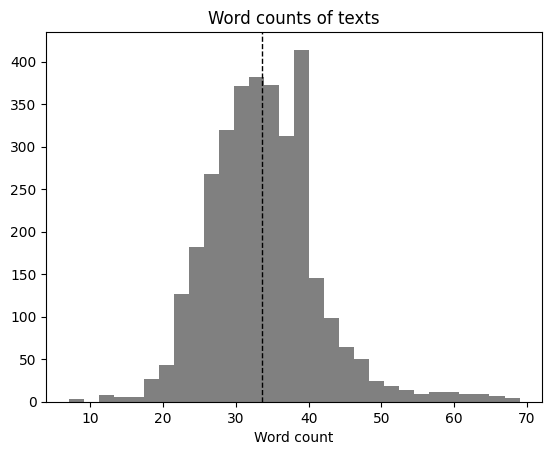

Maximum word count: 69
Minimum word count: 7
Mean word count: 34


In [8]:
from matplotlib import pyplot as plt
import numpy as np

# Show histogram plot
lengths = [len(text.replace("-", "").split(" ")) for text in texts]
plt.hist(lengths, bins=30, color="grey")
plt.axvline(np.mean(lengths), color='k', linestyle='dashed', linewidth=1)
plt.title("Word counts of texts")
plt.xlabel("Word count")
plt.show()

# Print statistics
print("Maximum word count:", max(lengths))
print("Minimum word count:", min(lengths))
print("Mean word count:", round(np.mean(lengths)))

#### Task 12: Pad sequences to unique length
Next the [Keras function pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) shall be applied to represent the set of all sequences as a numpy-array. The number of rows in this array is the number of sequences, the number of columns is the fixed sequence length `maxlen`. Choose an appropriate value for the fixed sequence length. 

Moreover, the labels-list shall be one-hot-encoded into a numpy-array `labels` with two columns. In this array the entry in row i, column j is 1, if the i.th text belongs to the class with label j, otherwise this entry is 0.

<font color="blue"><b>Comment:</b></font> We chose a sequence length of 80 which is slightly above the maximum article length in case this model would be used in the inference phase with a slightly longer article.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

seq_length = 80
padded_sequences = pad_sequences(sequences, maxlen=seq_length)
print(padded_sequences.shape)

(3315, 80)


In [10]:
from tensorflow.keras.utils import to_categorical
encoded_labels = to_categorical(labels, num_classes=2)
print(encoded_labels.shape)
print(encoded_labels)

(3315, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


### Split labeled texts in training- and validation set

#### Task 13: Create training- and validation-partition
The numpy-array of padded integer-sequences and the corresponding labels (as generated in the code cell above) shall be randomly shuffled and then split into a training- and a validation set. 80% of the labeled data is applied for training, the remaining 20% for validation. 

In [11]:
from sklearn.model_selection import train_test_split

# train_test_split automatically randomizes so no manual randomization is made
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, encoded_labels, test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(2652, 80)
(663, 80)
(2652, 2)
(663, 2)


### Load  and prepare Word-Embedding

#### Task 14: Load Word Embedding
Load the Word Embedding, which has been trained and saved in task 3.

In [12]:
from gensim.models.fasttext import load_facebook_model

model = load_facebook_model('./data/cc.de.300.bin.gz')

#### Task 15: Prepare `embeddings_index`
Next a Python dictionary `embeddings_index`, which maps words to their vector-representation must be generated.

In [13]:
embeddings_index = {}
# Iterates over the words and indices in the word_tokenizer object
for word, index in word_tokenizer.word_index.items():
    if word in model.wv: 
        # Gets the vector for the word and adds it to the dictionary
        embeddings_index[word] = model.wv[word]

#### Task 16:  Prepare `embeddings_matrix`

The variable `word_index` has been allocated in **Task 10**. It maps each word of the labeled documents (news) to a unique index. Now `word_index` as calculated from the labeled input documents for the classifier is combined with the `embedding_index`, which maps each word of the word-embedding (German wikipedia dump in this case) to it's vector representation. The result is the *numpy-array* `embedding_matrix`, which contains in the i.th row the vector representation of the word with index i in the `word_index`. Applying this `embedding_matrix` allows the *Keras*-module `Embedding` to map a sequence of word-indices, which represents a single news-item, to a sequence of word-vectors. 

![wordMappings](./Pics/wordMappings.png)



In [14]:
# word_index was named indicies by us
embedding_matrix = np.zeros((len(indicies) + 1, model.vector_size))

for word, index in indicies.items(): 
    if word in embeddings_index:
        embedding_matrix[index] = embeddings_index[word]

In [15]:
embedding_matrix.shape

(20653, 300)

### Define CNN architecture, train and evaluate
In Keras network architectures can either be defined as [Sequential models](https://keras.io/guides/sequential_model/) or by the [Functional API approach](https://keras.io/guides/functional_api/). For the implementations in this lecture you are free to choose any of both. 

#### Task 17: Define CNN architecture
The `embedding_matrix`, as generated in the previous task shall now be assigned to the `weights`-argument of a [Keras Embedding Layer](https://keras.io/api/layers/core_layers/embedding/). The Embedding Layer constitutes the input layer of the CNN. 

Following the input layer configure one or more cascades of `Conv1D`-layers, followed by `MaxPooling1D`-layers. Apply `relu`-activation in the conv-layers. 


After the last convolutional-layer a `GlobalMaxPooling1D`-layer shall be applied, followed by a dense layer with softmax-activation (for the binary classification actually a sigmoid-activation at the output would be enough).

Display a summary of this architecture by calling the `summary()`-function.

In [16]:
seq_model = Sequential() 
seq_model.add(Embedding(input_dim=len(indicies) + 1, output_dim=model.vector_size, input_length=80, weights=[embedding_matrix], trainable=False)) 
seq_model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(GlobalMaxPooling1D())
seq_model.add(Dense(units=2, activation='softmax'))

seq_model.summary()

2023-04-25 20:21:37.820819: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 300)           6195900   
_________________________________________________________________
conv1d (Conv1D)              (None, 78, 32)            28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1

2023-04-25 20:21:37.822619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-25 20:21:37.831419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-04-25 20:21:37.831449: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-25 20:21:37.834112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-25 20:21:37.834156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-04-25 20:21:37.835939: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.1

#### Task 18: Define Training
Hyperparameters for training a Keras model are defined by applying the `compile()`-method. Use `binary_crossentropy` as loss-function, `rmsprop` as learning-algorithm (optimizer) and `accuracy` as metric. 

In [17]:
seq_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#### Task 19:  Training and Validation
Apply the model's `fit()`-method for training. Assign training- and validation- data as generated in Task 13. Choose an appropriate `batch_size` and an appropriate number of `epochs`. 

After training is finished, plot the accuracy on the training- and validation-data over the epochs.

In [18]:
trained_model = seq_model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=0)

2023-04-25 20:21:38.593019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-25 20:21:38.593665: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2998455000 Hz
2023-04-25 20:21:39.062031: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-25 20:21:39.188248: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-04-25 20:21:39.786337: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-04-25 20:21:39.894304: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [19]:
import matplotlib.pyplot as plt

def plot_training(trained_model):
    plt.plot(trained_model.history['accuracy'], label='training accuracy') 
    plt.plot(trained_model.history['val_accuracy'], label='validation accuracy') 
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [46]:
np.save("embedding_matrix.npy", embedding_matrix)
print(len(indicies))
print(model.vector_size)
np.save("data.npy", [X_train, X_val, y_train, y_val])

20652
300


/opt/miniconda3/envs/python3/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  file = os_fspath(file)


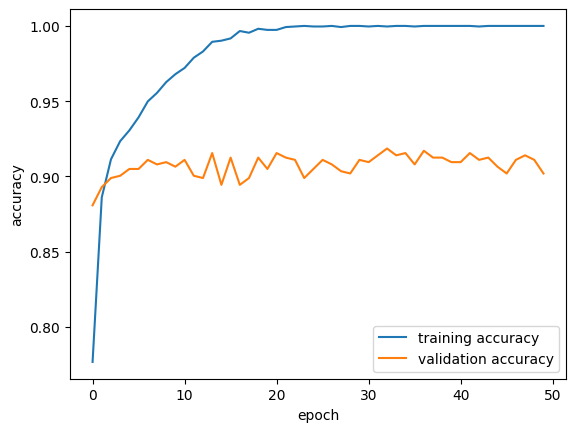

In [20]:
plot_training(trained_model)

<font color="blue"><b>Comment:</b></font> We can see that the model was able to accieve a training accuracy of 100% while the validation accuracy did not surpass about 90%. A 90% accuracy can be considered quite good. In the next section we try to improve this by trying different hyperparameters.

### Optimization
#### Task 20: Optimize CNN Architecture
Find a good CNN configuration by varying hyperparameters, such as number of layers, number of filters, filtersizes, etc. 


#### Testing more layers

In [21]:
seq_model = Sequential() 
seq_model.add(Embedding(input_dim=len(indicies) + 1, output_dim=model.vector_size, input_length=80, weights=[embedding_matrix], trainable=False)) 
seq_model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(Conv1D(filters=48, kernel_size=3, activation='relu'))
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(GlobalMaxPooling1D())
seq_model.add(Dense(units=2, activation='softmax'))

seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 300)           6195900   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 78, 32)            28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 48)            4656      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 18, 48)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 64)            9280      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 8, 64)            

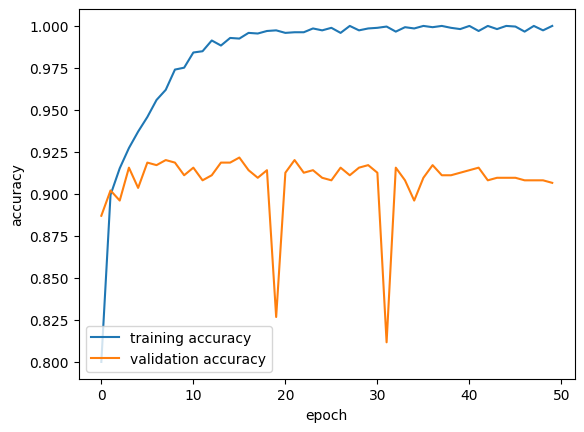

In [22]:
seq_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
trained_model = seq_model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=0)
plot_training(trained_model)

<font color="blue"><b>Comment:</b></font> Despite adding a 3rd convolutional layer, the accuracy did not improve. This shows us the model dept was of sufficient size in the first iteration.

#### Testing smaller filter size 

In [23]:
seq_model = Sequential() 
seq_model.add(Embedding(input_dim=len(indicies) + 1, output_dim=model.vector_size, input_length=80, weights=[embedding_matrix], trainable=False)) 
seq_model.add(Conv1D(filters=8, kernel_size=3, activation='relu')) 
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(GlobalMaxPooling1D())
seq_model.add(Dense(units=2, activation='softmax'))

seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 300)           6195900   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 78, 8)             7208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 8)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 37, 16)            400       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 18, 16)            0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

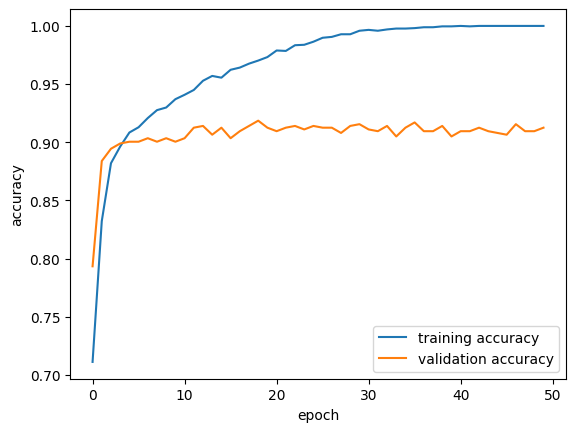

In [24]:
seq_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
trained_model = seq_model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=0)
plot_training(trained_model)

<font color="blue"><b>Comment:</b></font> When testing the model with fewer filters, the accuracy also stayed the same. One notable observation was that the training accuracy took more epochs to converge at 100%

#### Testing filter size variation from many to few (previously was few to many)

In [25]:
seq_model = Sequential() 
seq_model.add(Embedding(input_dim=len(indicies) + 1, output_dim=model.vector_size, input_length=80, weights=[embedding_matrix], trainable=False)) 
seq_model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(GlobalMaxPooling1D())
seq_model.add(Dense(units=2, activation='softmax'))

seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 300)           6195900   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 78, 32)            28832     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 37, 8)             776       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 18, 8)             0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

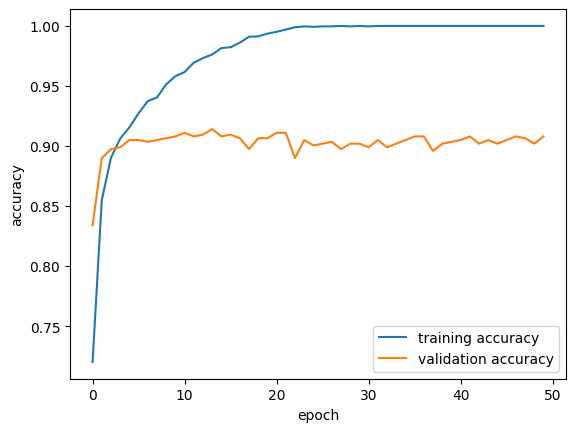

In [26]:
seq_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
trained_model = seq_model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=0)
plot_training(trained_model)

<font color="blue"><b>Comment:</b></font> Another test we performed was decreasing the filter amounts towards the end of the model instead of them increasing like before. This also did not improve the accuracy.

#### Testing with smaller learning rate

In [27]:
seq_model = Sequential() 
seq_model.add(Embedding(input_dim=len(indicies) + 1, output_dim=model.vector_size, input_length=80, weights=[embedding_matrix], trainable=False)) 
seq_model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(GlobalMaxPooling1D())
seq_model.add(Dense(units=2, activation='softmax'))

seq_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 300)           6195900   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 78, 32)            28832     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 37, 64)            6208      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 18, 64)            0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

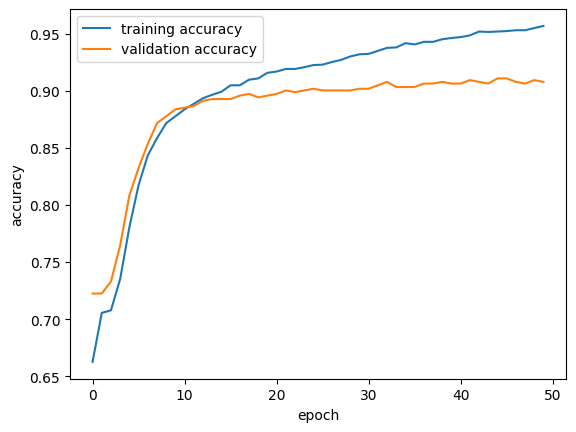

In [28]:
seq_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])
trained_model = seq_model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=0)
plot_training(trained_model)

<font color="blue"><b>Comment:</b></font> The last hyperparameter change we decided to test out was decreasing the learning rate. This resulted in the model taking longer to converge which was expected. This however did not result in a better accuracy.

## Further ideas
If no embedding_matrix is assigned to the `weights`-argument of the `EmbeddingLayer` and the `trainable`-argument is set to be `True`, then the weights of the EmbeddingLayer are learned during training of the entire network. I.e. in this case no pre-trained word-embedding is required. It would be nice to compare this approach with the approach where pre-trained weights are applied. 

As an alternative to the CNN a LSTM-architecture, e.g. a single LSTM-Layer, followed by Dropout and a Dense Layer at the output, can be applied for classification. The input-embedding layer would be the same as for the CNN. 

#### Training embedding layer weights

In [29]:
seq_model = Sequential() 
seq_model.add(Embedding(input_dim=len(indicies) + 1, output_dim=model.vector_size, input_length=80, trainable=True)) 
seq_model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
seq_model.add(MaxPooling1D(pool_size=2))
seq_model.add(GlobalMaxPooling1D())
seq_model.add(Dense(units=2, activation='softmax'))

seq_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 80, 300)           6195900   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 78, 32)            28832     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 39, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 37, 64)            6208      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 18, 64)            0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

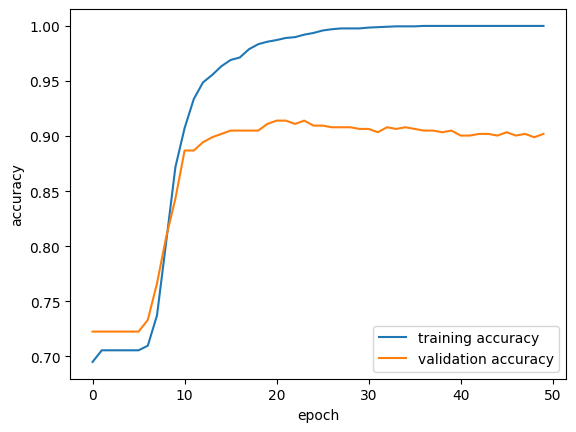

In [30]:
seq_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])
trained_model = seq_model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=0)
plot_training(trained_model)

<font color="blue"><b>Comment:</b></font> When we modify our model to also train the word embeddings, the validation accuracy got slightly worse, and the model took longer to converge. This was expected by us as we have more parameters to train, and the word embeddings have fewer training data fine tune their parameters.

#### Testing an LSTM model

For this task we had to switch to google colab as there was an unfixable error on the HDM cluster. The following cells are copied over from an identical google colab notebook

In [37]:
from tensorflow.keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(indicies) + 1, output_dim=model.vector_size, input_length=80, weights=[embedding_matrix], trainable=False))
lstm_model.add(LSTM(units=32))
lstm_model.add(Dropout(rate=0.2))
lstm_model.add(Dense(units=2, activation='softmax'))

lstm_model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm_4/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
lstm_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])
trained_model = lstm_model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=0)
plot_training(trained_model)

<font color="blue"><b>Comment:</b></font> 